In [1]:
# Import libraries
import pandas as pd
import numpy as np

# Load datasets
train_df = pd.read_csv(r"D:\GUVI AIML\Projects\Insurance Premium Prediction Model\Insurance Premium Dataset\train.csv")
test_df = pd.read_csv(r"D:\GUVI AIML\Projects\Insurance Premium Prediction Model\Insurance Premium Dataset\test.csv")
sample_sub = pd.read_csv(r"D:\GUVI AIML\Projects\Insurance Premium Prediction Model\Insurance Premium Dataset\sample_submission.csv")

print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)
train_df.head()


Train shape: (1200000, 21)
Test shape: (800000, 20)


,id,Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,...,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Policy Start Date,Customer Feedback,Smoking Status,Exercise Frequency,Property Type,Premium Amount
0,0,19.0,Female,10049.0,Married,1.0,Bachelor's,Self-Employed,22.598761,Urban,...,2.0,17.0,372.0,5.0,2023-12-23 15:21:39.134960,Poor,No,Weekly,House,2869.0
1,1,39.0,Female,31678.0,Divorced,3.0,Master's,NaN,15.569731,Rural,...,1.0,12.0,694.0,2.0,2023-06-12 15:21:39.111551,Average,Yes,Monthly,House,1483.0
2,2,23.0,Male,25602.0,Divorced,3.0,High School,Self-Employed,47.177549,Suburban,...,1.0,14.0,NaN,3.0,2023-09-30 15:21:39.221386,Good,Yes,Weekly,House,567.0
3,3,21.0,Male,141855.0,Married,2.0,Bachelor's,NaN,10.938144,Rural,...,1.0,0.0,367.0,1.0,2024-06-12 15:21:39.226954,Poor,Yes,Daily,Apartment,765.0
4,4,21.0,Male,39651.0,Single,1.0,Bachelor's,Self-Employed,20.376094,Rural,...,0.0,8.0,598.0,4.0,2021-12-01 15:21:39.252145,Poor,Yes,Weekly,House,2022.0


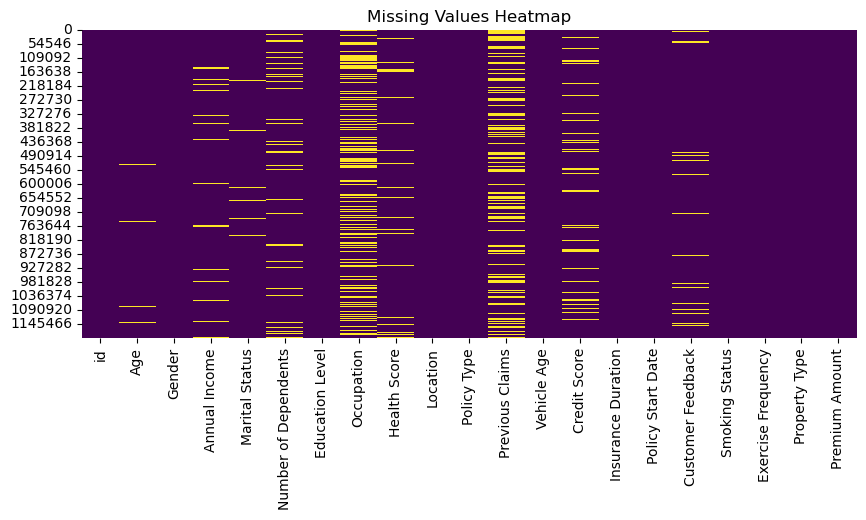

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

# Missing values
plt.figure(figsize=(10,4))
sns.heatmap(train_df.isnull(), cbar=False, cmap="viridis")
plt.title("Missing Values Heatmap")
plt.show()


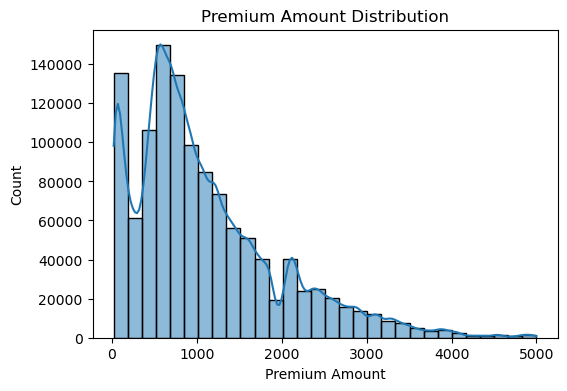

In [3]:
# Distribution of target variable
plt.figure(figsize=(6,4))
sns.histplot(train_df['Premium Amount'], bins=30, kde=True)
plt.title("Premium Amount Distribution")
plt.show()


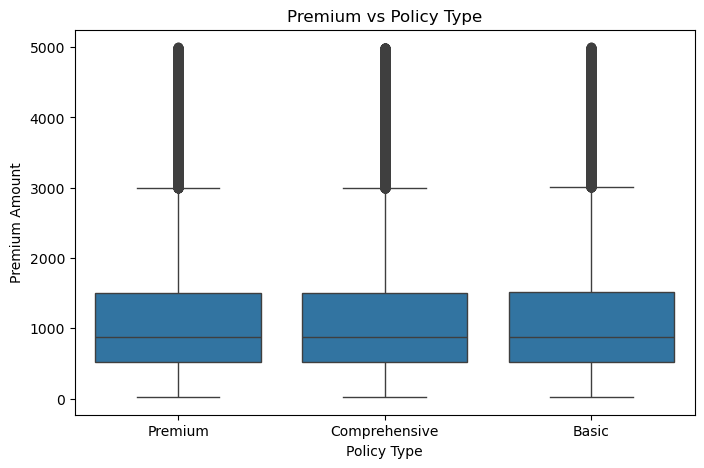

In [4]:
# Policy Type vs Premium
plt.figure(figsize=(8,5))
sns.boxplot(x='Policy Type', y='Premium Amount', data=train_df)
plt.title("Premium vs Policy Type")
plt.show()


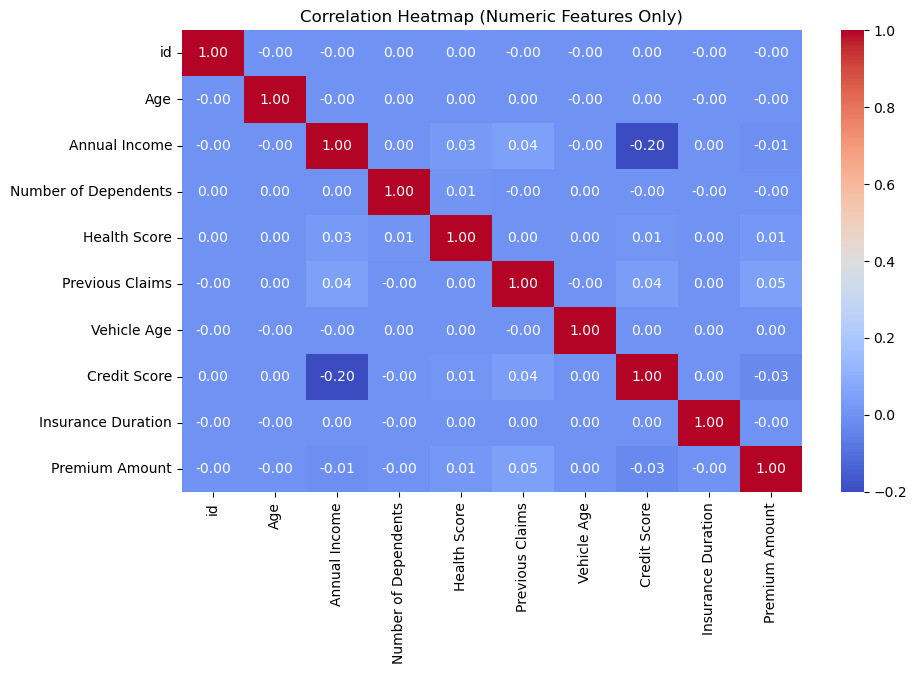

In [5]:
# Correlation heatmap (only numeric features)
plt.figure(figsize=(10,6))
numeric_df = train_df.select_dtypes(include=['int64','float64'])
sns.heatmap(numeric_df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap (Numeric Features Only)")
plt.show()


In [6]:
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Drop non-predictive columns
train_df = train_df.drop(['id','Policy Start Date'], axis=1)
test_df = test_df.drop(['id','Policy Start Date'], axis=1)

# Features and target
X = train_df.drop('Premium Amount', axis=1)
y = train_df['Premium Amount']

# Identify column types
num_cols = X.select_dtypes(include=['int64','float64']).columns
cat_cols = X.select_dtypes(include=['object']).columns

# Pipelines
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

# Column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols)
    ])

# Train-val split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [7]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

# Candidate models
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(max_depth=12, random_state=42),
    "Random Forest": RandomForestRegressor(
        n_estimators=100, max_depth=15, max_features="sqrt", n_jobs=-1, random_state=42),
    "XGBoost": xgb.XGBRegressor(
        n_estimators=200, learning_rate=0.05, max_depth=8,
        subsample=0.8, colsample_bytree=0.8, random_state=42, n_jobs=-1)
}


In [8]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

results = {}
for name, model in models.items():
    pipe = Pipeline(steps=[("preprocessor", preprocessor),
                           ("model", model)])
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_val)

    rmse = mean_squared_error(y_val, preds) ** 0.5
    mae = mean_absolute_error(y_val, preds)
    r2 = r2_score(y_val, preds)

    results[name] = {"RMSE": rmse, "MAE": mae, "R2": r2}

pd.DataFrame(results).T


,RMSE,MAE,R2
Linear Regression,863.342961,667.325213,0.002575
Decision Tree,855.475648,646.365491,0.020671
Random Forest,853.822218,657.831832,0.024453
XGBoost,846.539839,645.037131,0.041023


In [9]:
import mlflow
import mlflow.sklearn

with mlflow.start_run():
    best_model = RandomForestRegressor(
        n_estimators=100, max_depth=15, max_features="sqrt", n_jobs=-1, random_state=42)
    
    pipe = Pipeline(steps=[("preprocessor", preprocessor),
                           ("model", best_model)])
    
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_val)

    rmse = mean_squared_error(y_val, preds) ** 0.5
    mae = mean_absolute_error(y_val, preds)
    r2 = r2_score(y_val, preds)

    mlflow.log_metric("rmse", rmse)
    mlflow.log_metric("mae", mae)
    mlflow.log_metric("r2", r2)

    mlflow.sklearn.log_model(pipe, "premium_predictor")


2025/09/02 07:06:21 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/09/02 07:06:37 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [10]:
import joblib

joblib.dump(pipe, "premium_predictor.pkl")


['premium_predictor.pkl']